In [1]:
import ehrapy.api as ep
import pandas as pd

Unable to contact PyPI to check for the latest ehrapy version. Do you have an internet 
connection?

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/medcat/cat.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
ep.settings.n_jobs=8

In [3]:
# !wget https://medcat.rosalind.kcl.ac.uk/media/vocab.dat -P ./data/
# !wget https://medcat.rosalind.kcl.ac.uk/media/cdb-medmen-v1.dat -P ./data/
# !wget https://raw.githubusercontent.com/CogStack/MedCAT/master/tutorial/data/pt_notes.csv -P ./data/

In [4]:
medcat = ep.tl.MedCAT()

vocabulary = medcat.load_vocabulary("data/vocab.dat")
concept_db = medcat.load_concept_db("data/cdb-medmen-v1.dat")

concept_db.config.ner['min_name_len'] = 2
concept_db.config.ner['upper_case_limit_len'] = 3
concept_db.config.general['spell_check'] = True
concept_db.config.linking['train_count_threshold'] = 10
concept_db.config.linking['similarity_threshold'] = 0.3
concept_db.config.linking['train'] = True
concept_db.config.linking['disamb_length_limit'] = 5
concept_db.config.general['full_unlink'] = True

medcat.update_cat(vocabulary=vocabulary, concept_db=concept_db)

In [5]:
text = "He was diagnosed with kidney failure"
doc = medcat.cat(text)
doc.ents

(diagnosed, kidney failure)

In [6]:
medcat.cat.get_entities("He was diagnosed with kidney failure", only_cui=False)

{'entities': {0: {'pretty_name': 'Diagnosis Study',
   'cui': 'C1704656',
   'tuis': ['T062'],
   'types': ['Research Activity'],
   'source_value': 'diagnosed',
   'detected_name': 'diagnosed',
   'acc': 0.22160544957937056,
   'context_similarity': 0.22160544957937056,
   'start': 7,
   'end': 16,
   'icd10': [],
   'ontologies': [],
   'snomed': [],
   'id': 0,
   'meta_anns': {}},
  2: {'pretty_name': 'Kidney Failure',
   'cui': 'C0035078',
   'tuis': ['T047'],
   'types': ['Disease or Syndrome'],
   'source_value': 'kidney failure',
   'detected_name': 'kidney~failure',
   'acc': 1.0,
   'context_similarity': 1.0,
   'start': 22,
   'end': 36,
   'icd10': [],
   'ontologies': [],
   'snomed': [],
   'id': 2,
   'meta_anns': {}}},
 'tokens': []}

In [7]:
data = pd.read_csv("data/pt_notes.csv")

In [8]:
data.head()

,Unnamed: 0_x,subject_id,chartdate,category,text,create_year,Unnamed: 0_y,gender,dob,dob_year,age_year
0,6,1,2079-01-01,General Medicine,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079,1,F,2018-01-01,2018,61
1,7,1,2079-01-01,Rheumatology,"HISTORY OF PRESENT ILLNESS: , A 71-year-old fe...",2079,1,F,2018-01-01,2018,61
2,8,1,2079-01-01,Consult - History and Phy.,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079,1,F,2018-01-01,2018,61
3,9,2,2037-01-01,Consult - History and Phy.,"CHIEF COMPLAINT:,1. Infection.,2. Pelvic pai...",2037,2,F,2018-01-01,2018,19
4,10,2,2037-01-01,Dermatology,"SUBJECTIVE:, This is a 29-year-old Vietnamese...",2037,2,F,2018-01-01,2018,19


@FIL ZLAUS HERE WE NEED THE DF TO BE AN ANNDATA OBJECT.

In [9]:
# medcat.cat.train(data.text.values, progress_print=100)

In [10]:
medcat.cat.cdb.print_stats()

Number of concepts: 34,724
Number of names:    92,740
Number of concepts that received training: 34,724
Number of seen training examples in total: 4,079,076
Average training examples per concept:     117.5


In [11]:
filtered_cdb = medcat.filter_tui(medcat.concept_db, ['T047', 'T048'])

The size of the concept database is now: 1763

In [12]:
medcat.update_cat(vocabulary=vocabulary, concept_db=filtered_cdb)

@FIL ZLAUS THE ANNOTATION SHOULD RUN ON A COLUMN IN X.
ALSO, THE ONLY_CUI MUST BE TRUE ATM BECAUSE set(result["entities"].values()) CAN T BE HASHED. (THE RESULT IS A DICTIONARY).
GOAL: ALLOW FOR ONLY_CUI=FALSE. SHOULD BE RATHER EASY FIXES, JUST NEED TO GENERALIZE IT A LITTLE BIT MORE.

In [13]:
annotation = medcat.annotate(data["text"], only_cui=True)

Output()

Annotated until now: 0 docs; Current BS: 101 docs
Annotated until now: 0 docs; Current BS: 101 docs
Annotated until now: 0 docs; Current BS: 101 docs
Annotated until now: 0 docs; Current BS: 101 docs
Annotated until now: 0 docs; Current BS: 101 docs
Annotated until now: 0 docs; Current BS: 101 docs
Annotated until now: 0 docs; Current BS: 101 docs
Annotated until now: 0 docs; Current BS: 101 docs
Annotated until now: 0 docs; Current BS: 78 docs


THE RESULTS SHOULD ALSO BE ADDED TO THE ANNDATA OBJECT IN OBS NOW.

In [15]:
subjects_diseases_pcts = medcat.calculate_disease_proportions(annotation.cui_locations,
                                                              data,
                                                              subject_id_col="subject_id")

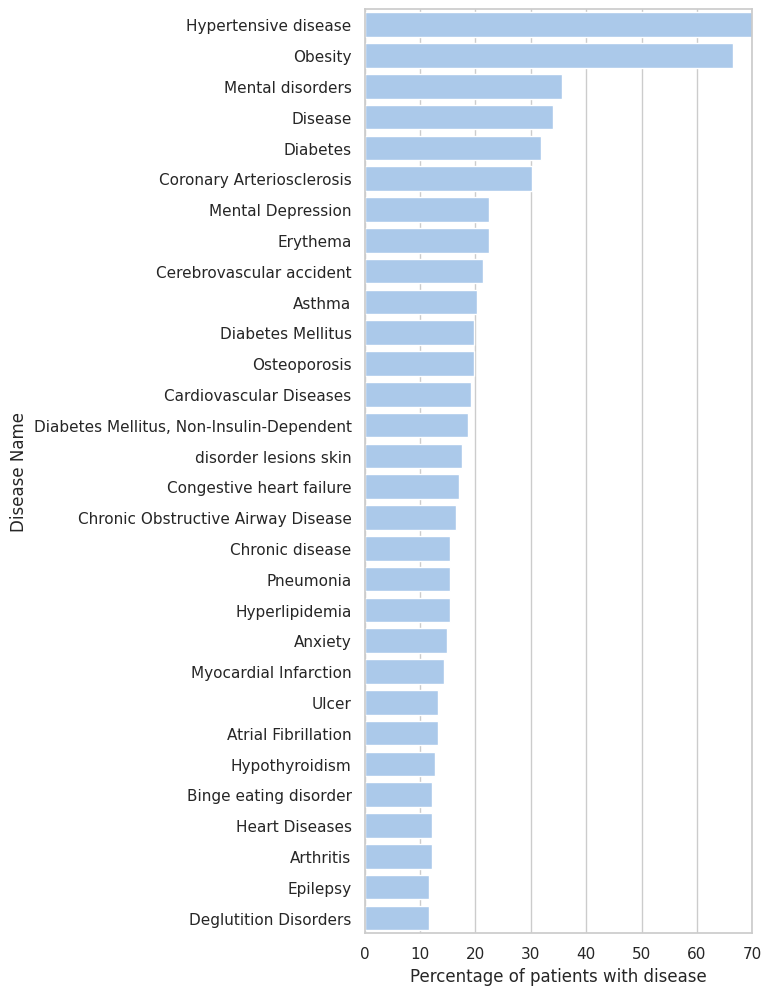

In [16]:
medcat.plot_top_diseases(subjects_diseases_pcts, 30)